<center>
    
# LightGBM algorithm to predict calls volume in a Call Center
    
</center>

This notebook uses Call Center data from 2019. The data is for one year of call logs. The Call Center Managers want to measure its performance based on certain metrics. The managers want to rise the metrics by improving the Workforce Management (WFM) process of scheduling and staffing agents. A machine learning approach is proposed as follows:

1. Predict the daily calls volume 
2. Split the daily calls volume hourly

The Microsoft LightGBM algorithm is used to do the predictions.

**Importing libraries and data**

In [1]:
from utils import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,6)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

**Data Preparation**

1. The data in the files is monthly data corresponding to call center logs. The calls are registered as soon as they arrive to the call center. Aggregating by seconds or by minutes is useless since the theory of call centers suggest that the daily behavior of a call center is a Poisson model of hourly variable rate.

2. Another important thing in the theory of modeling call centers is that the calls volume and the rates are also dependent on the day of the week. The present analysis use the day of the month instead to smooth the seasonality (usually weekly) to monthly seasonality. In this way, the missing data imputation is less prompt to bias.

3. A target variable `calls volume` is created to register hourly calls volume. The numerical values of number of abandon calls, prequeue, inqueue, agent_time, postqueue, total_time and global sla achieve per hour are used as covariates (a covariate can be thought as a regressor).

In [3]:
# Load the yearly dataframe for prediction
yearly = get_yearly_frame()
yearly.sample(5, random_state = 42)

,,,abandon,prequeue,inqueue,agent_time,postqueue,total_time,sla,calls_volume
day,hour,month,,,,,,,,
10,9,9,4.0,9.948980,16.051020,144.061224,0.112245,169.051020,1.0,98.0
20,17,8,8.0,29.375000,0.000000,0.000000,0.000000,0.000000,-1.0,8.0
7,18,9,1.0,13.920635,0.365079,217.904762,0.095238,232.142857,1.0,63.0
16,21,11,6.0,8.685393,40.943820,195.235955,0.224719,240.775281,1.0,89.0
19,10,5,53.0,9.992126,138.637795,136.196850,0.094488,244.779528,1.0,127.0


## **Using LightGBM**

Consider the target variable `calls_volume` with historical data of 1 year. The frequency of this variable is hourly (`H`). The covariates for this predictions will be `prequeue`, `inqueue`, `agent_time`, and `postqueue` features of the data frame.

In [4]:
from darts import TimeSeries
from darts.models import LightGBMModel

from darts.metrics import coefficient_of_variation, mae

Using Darts library, create the time series for the `calls_volume` target variable and the multi time series for the `features`. 

In [5]:
# Get the dataframe for the year correctly formatted
df = get_formatted_time_series_frame_from(data=yearly, year="2019")

# Split Dataframe in Variables and Features
variable = df['calls_volume']
features = df[['prequeue', 'inqueue', 'agent_time', 'postqueue']] # 'total_time', 'abandon', 'sla'

# Get the darts Time Series objects
ts_variable = TimeSeries.from_series(variable,
                                     freq='H')
ts_features = TimeSeries.from_dataframe(features, 
                                        freq='H')

### **Use of Light GBM to forecast hourly calls volume - Self historical test**

As the above description suggest, the weekly seasonal behavior of 7 days impose to look back to the same amount of time in the covariates. This is the reason to select $24\times 7=168$ lags past covariates. 

In [6]:
# Works well with 24, 48, and 168 hrs.
model_lightgbm = LightGBMModel(lags = 168,
                               lags_past_covariates = 168,
                               output_chunk_length = 10,
                               # likelihood = 'poisson',
                               quantiles = [0.1, 0.9],
                               random_state = 42
                              )

Train the model in the ts_variable and the ts_features

In [7]:
model_lightgbm.fit(series=ts_variable,
                   past_covariates=ts_features)

Instead of making new predictions with the model, use it to generate a historical forecast. In this sense, the performance of the algorithm is measure  for one year of data, and the validity of the results will generalize

In [8]:
pred_series = model_lightgbm.historical_forecasts(series=ts_variable,
                                                  forecast_horizon=7,
                                                  stride=1, 
                                                  retrain=False,
                                                  verbose=True,
                                                 )

  0%|          | 0/4375 [00:00<?, ?it/s]

**Visualizing the historical prediction**

Plot the last week of the actual data against the predicted historical data. It shows an accuracy of around 73 % according to R-RMSE metric.

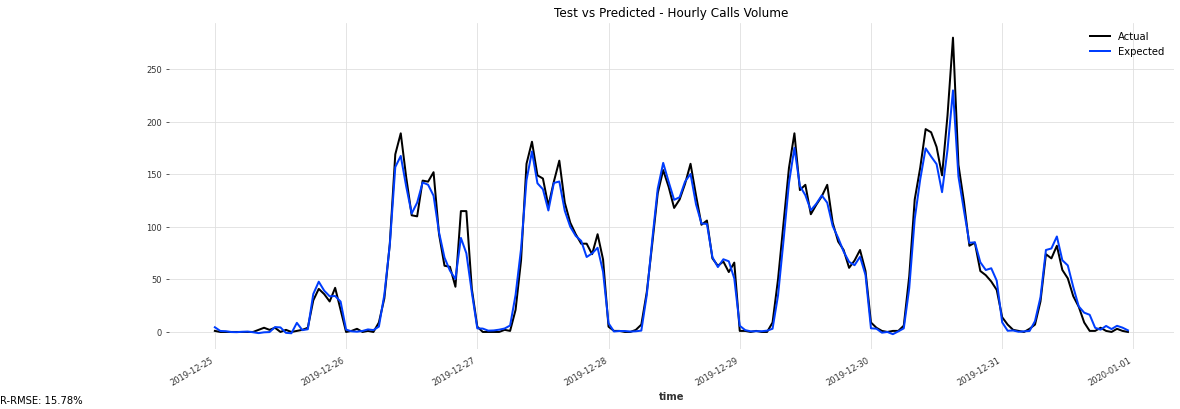

In [9]:
plot_prediction_and_test(target = ts_variable[-168:],
                         prediction= pred_series[-168:]);

### **Use of Light GBM to forecast hourly calls volume - Testing with features**

Since one week is around 2 % of a year, select 5 % of the data to be the test set and the 95% to be the training set.

In [10]:
# Split the dataset into train / set
train_variable, test_variable = ts_variable.split_after(0.95)
train_features, test_features = ts_features.split_after(0.95)

The light GBM model has lags of 168 periods (this mean 1 week) that matches also the past covariates lags. 

In [11]:
test_model = LightGBMModel(lags = 168,
                           lags_past_covariates = 168,
                           output_chunk_length = 10,
                           likelihood = 'poisson',
                           quantiles = [0.1, 0.9],
                           random_state = 42
                          )

In [12]:
# Train the model in the corresponding train time series
test_model.fit(series=train_variable,
               past_covariates=train_features)

In [13]:
prediction = test_model.predict(n=len(test_variable),
                                num_samples=100,
                                series=train_variable,
                                past_covariates=ts_features)

**Visualizing the test prediction**

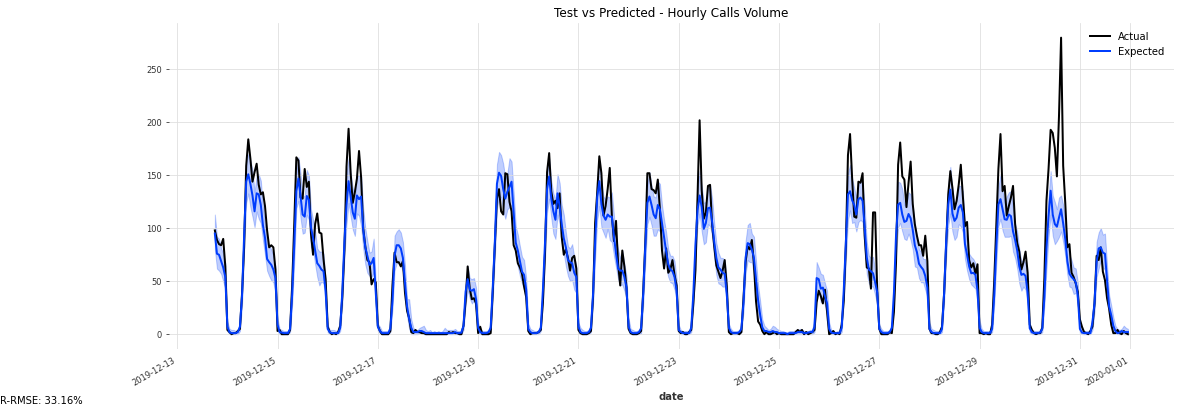

In [14]:
plot_prediction_and_test(target=test_variable, 
                         prediction=prediction);

### **Resampling the prediction**

Scheduling staff in the call center gets improved when the aggregation time is for one shift of 8 hours. By just resampling the prediction and test variables, the R-RMSE improves for almost 5 %

In [15]:
r_train_variable = train_variable.resample(freq='8h',
                                           method='pad')
r_test_variable = test_variable.resample(freq='8h', 
                                         method='pad')
r_prediction = prediction.resample(freq='8h',
                                   method='pad')

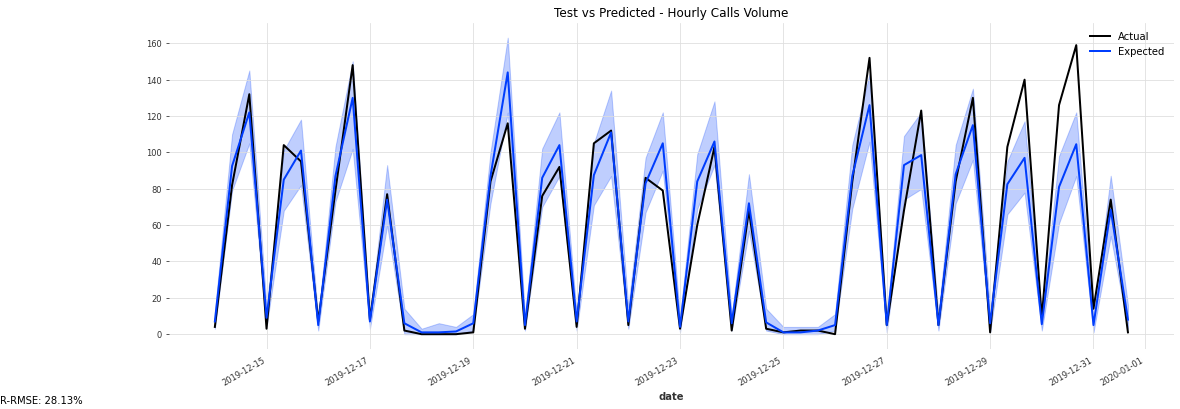

In [16]:
plot_prediction_and_test(target= r_test_variable, 
                         prediction=r_prediction);

**Plotting the resampled series with train set included**

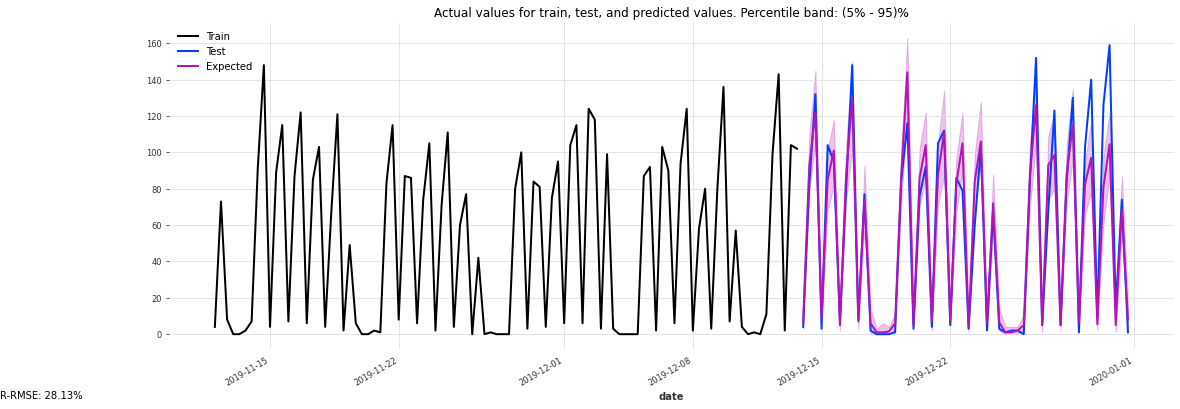

In [17]:
plot_predict(train_target=r_train_variable[-96:],
             test_target=r_test_variable,
             prediction=r_prediction,
             low_percentile=0.05);